In [29]:
import argparse
import os
import sys
import time
import numpy as np
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import urllib
import time

from einops import repeat, rearrange

This is following the model from LucidRains with some advisement from the original code

https://github.com/lucidrains/ESBN-pytorch

# helper functions

In [2]:
def exists(val):
    return val is not None

In [3]:
def safe_cat(t, el, dim =0):
    if not exists(t):
        return el
    return tf.concat((t, el), axis = dim)

In [4]:
def map_fn(fn, *args, **kwargs):
    def inner(*arr):
        return map(lambda t: fn(t, *args, **kwargs), arr)
    return inner

# the Class

In [81]:
class ESBN(keras.layers.Layer):
    def __init__(
        self,
        *,
        value_dim = 64,
        key_dim = 64, #256?
        hidden_dim = 512,
        output_dim = 4,
        encoder = None
    ):
        super().__init__()
        self.output_dim = output_dim
        self.h0 = tf.zeros(hidden_dim)
        self.c0 = tf.zeros(hidden_dim)
        self.k0 = tf.zeros(key_dim + 1)
        
        # self.h0 = tf.random.uniform([hidden_dim])
        # self.c0 = tf.random.uniform([hidden_dim])
        # self.k0 = tf.random.uniform([key_dim + 1])
        
        self.lstm = tf.keras.layers.LSTMCell(hidden_dim)  #What is the difference between this and just LSTM
        self.to_gate = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) #?
        self.to_key = tf.keras.layers.Dense(key_dim)
        self.to_output = tf.keras.layers.Dense(output_dim)
        
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.Reshape((32, 32, 1))) #to deal with shape issue
        self.encoder.add(tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, 
                                                activation=tf.keras.activations.relu))
        self.encoder.add(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2,
                                                activation=tf.keras.activations.relu))
        self.encoder.add(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2,
                                                activation=tf.keras.activations.relu))
        self.encoder.add(tf.keras.layers.Flatten())
        self.encoder.add(tf.keras.layers.Dense(value_dim))
                         # if not exists(encoder) else encoder What does???
            
        self.to_confidence = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        self.to_something = tf.keras.layers.Dense(65)
        
    def call(self, images):
        #return images
        print('images shape: ', images.shape)
        b = images.shape[1] #what exactly is this
        print('b shape ', b)
        # Mk = tf.zeros((tf.shape(images)[0], 0, 64)) #keys
        # Mv = tf.zeros((tf.shape(images)[0], 0, 64)) #values
        Mk = tf.zeros((tf.shape(images)[0], 64)) #keys
        Mv = tf.zeros((tf.shape(images)[0], 64)) #values
        # Mk = tf.random.uniform((tf.shape(images)[0], 0, 64))
        # Mv = tf.random.uniform((tf.shape(images)[0], 0, 64))
        
        
        #hx, cx, kx, k0 = map_fn(repeat, 'd -> b d', b = b)(self.h0, self.c0, self.k0, self.k0)
        # hx = tf.zeros((tf.shape(images)[0], 1, self.h0.shape[-1])) #hidden states
        # cx = tf.zeros((tf.shape(images)[0], 1, self.c0.shape[-1])) #confidence intervals?
        # kx = tf.zeros((tf.shape(images)[0], 1, self.k0.shape[-1])) #next input
        # k0 = tf.zeros((tf.shape(images)[0], 1, self.k0.shape[-1])) #redundent???
        hx = tf.zeros((tf.shape(images)[0], self.h0.shape[-1])) #hidden states
        cx = tf.zeros((tf.shape(images)[0], self.c0.shape[-1])) #confidence intervals?
        kx = tf.zeros((tf.shape(images)[0], self.k0.shape[-1])) #next input
        k0 = tf.zeros((tf.shape(images)[0], self.k0.shape[-1])) #redundent???
     
        out = tf.TensorArray(dtype=tf.float32,
                             size=tf.shape(images)[1],
                             dynamic_size=True)

        print("out size after creation: ", out.size())
        #ind = tf.Variable(0, trainable=False, dtype=tf.int32)
        ind = tf.constant(0)
        i = 0

        #for ind, image in enumerate(images):
        def body(ind, out):
            nonlocal Mk, Mv, hx, cx, kx, k0, b, i
            #nonlocal images
            
            image = images[:,ind,:,:]
            print('in loop single shape:',image.shape)
            #is_first = ind == 0
            is_first = i == 0
            z = self.encoder(image) #image encodings/
            print('z : ', z.shape)
            print('kx ', kx)
            print('hx : ', hx.shape)
            print('cx : ', cx)
            hx, cx = self.lstm(kx, (hx, cx)) #are we sure this is returning the right things?
            
            y, g, kw = self.to_output(hx), self.to_gate(hx), self.to_key(hx)
            
            # if is_first: #redundent?
            #     kx = k0
            # else:
            if not is_first:
                # attention
                #sim = tf.einsum('b n d, b d -> b n', Mv, z)
                # wk = tf.keras.layers.Activation(activation=tf.keras.activations.softmax)(sim)
                #wk = tf.nn.softmax(sim) #weights
                print("Mv shape: ", Mv.shape)
                dot = tf.tensordot(Mv, z, axes=1)
                test = self.to_something(dot)
                wk = tf.nn.softmax(test)
                print("test : ", test.shape)
                print("dot : ", dot.shape)
                print("wk : ", wk.shape)
                # calculate confidence
                #sim, wk = map_fn(rearrange, 'b n -> b n ()')(sim, wk) #consider
                #ck = self.to_confidence(sim)
                #ck = a logistic sigmoid with trainable paremeters gamma and beta???
                ck = self.to_confidence(dot)
                print("ck : ", ck.shape)
                #kx = g.sigmoid() * (wk * torch.cat((Mk, ck), dim = -1)).sum(dim = 1)
                cc = tf.keras.layers.concatenate([Mk, ck], axis=-1) #verified to work the same
                print("cc : ", cc.shape)
                cc = tf.math.reduce_sum(wk * cc, axis = 1) #same as torch.sum
                print("cc : ", cc.shape)
                kx = g * cc
                
            #kw, z = map_fn(rearrange, 'b d -> b () d')(kw, z)
            print("=======")
            print("Mk : ", Mk.shape)
            print("kw : ", kw.shape)
            print("Mv : ", Mv.shape)
            print("z : ", z.shape)
            Mk = safe_cat(Mk, kw, dim = 1)
            Mv = safe_cat(Mv, z, dim = 1) 

            #out.write(ind, y)
            out = out.write(i, y)
            print("i : ", i)
            i += 1
            print("then i : ", i)
            print("y : ", y.shape)
            print("?? out : ", out.read(i))
            return [ind + 1, out]
                
        
        
        # tf.while_loop(
        #     lambda i,ind: i < tf.shape(images)[1] + 1,
        #     body, 
        #     [ind, out])
        ind, out = tf.while_loop(
            lambda i,ind: i < tf.shape(images)[1] + 1,
            body, 
            [ind, out])
        
        out = out.read(images.shape[1]-1)
        print("out : ", out)
        #return out.stack() 
        return out
                

# Same-Difference

In [6]:
#This is all part of the args mess in their code
#initially setting this to be theri defaults

#Model Settings
model_name = 'ESBN'
norm_type = 'contextnorm'
encoder = 'conv'
#Task settings
task = 'same_diff'
train_gen_mathod = 'full_space'
n_shapes = 100 #total num of shapes available for training/testing
m_holdout = 0 #number of objects (out of n) withheld during training
#Training Settings
train_batch_size = 32
train_set_size = 10000
train_proportion = 0.95
lr = 5e-4
epochs = 50
log_interval = 10
#Test settings
test_batch_size = 100
test_set_size = 10000
#Device Settings
no_cuda = False #Actions??? 'store_true'
device = 0 
#run number
run = 1

In [7]:
all_shapes = np.arange(n_shapes)
np.random.shuffle(all_shapes)
all_shapes.shape

(100,)

In [8]:
if(m_holdout > 0):
    train_shapes = all_shapes[m_holdout:]
    test_shapes = all_shapes[:m_holdout]
else:
    train_shapes = all_shapes
    test_shapes = all_shapes
    
train_shapes.shape

(100,)

In [9]:
#now we're in their function
import sys
import random
import numpy as np

# Prevent python from saving out .pyc files
sys.dont_write_bytecode = True

y_dim = 2
seq_len = 2

In [10]:
# If m = 0, training and test sets are drawn from same set of shapes
if(m_holdout == 0):
    # Total number of possible trials
    shapes_avail = n_shapes
    total_trials = (shapes_avail * (shapes_avail - 1)) * 2
    
    # Proportion of training set size vs test set size
    test_proportion = 1 - train_proportion
    
    # Create training/test set sizes
    train_set_size = np.round(train_proportion * total_trials).astype(np.int32)
    test_set_size = np.round(test_proportion * total_trials).astype(np.int32)
    
else: 
    # Ensure that there are enough potential trials for desired training set size 
    # (or change train set size)
    shapes_avail = n_shapes - m_holdout
    total_trials = (shapes_avail * (shapes_avail - 1)) * 2
    
    if(train_set_size > total_trials):
        train_set_size = total_trials
    
    # Ensure that there are enough potential trials for desired test set size 
    # (or change test set size)
    shapes_avail = n_shapes - (n_shapes - m_holdout)
    total_trials = (shapes_avail * (shapes_avail - 1)) * 2
    
    if(test_set_size > total_trials):
        test_set_size = total_trials

train_set_size

18810

In [11]:
# If m = 0, training and test sets are drawn from same set of shapes
if m_holdout == 0:
    # Create all possible trials
    same_trials = []
    diff_trials = []
    for shape1 in train_shapes:
        for shape2 in train_shapes:
            if shape1 == shape2:
                same_trials.append([shape1, shape2])
            else:
                diff_trials.append([shape1, shape2])
    # Shuffle
    random.shuffle(same_trials)
    random.shuffle(diff_trials)
    # Split trials for train and test sets
    same_trials_train = same_trials[:np.round(train_proportion * len(same_trials)).astype(np.int32)]
    same_trials_test = same_trials[np.round(train_proportion * len(same_trials)).astype(np.int32):]
    diff_trials_train = diff_trials[:np.round(train_proportion * len(diff_trials)).astype(np.int32)]
    diff_trials_test = diff_trials[np.round(train_proportion * len(diff_trials)).astype(np.int32):]
# Otherwise, training and test sets are completely disjoint (in terms of the shapes that are used), and can be generated separately
else:
    # Create all possible training trials
    same_trials_train = []
    diff_trials_train = []
    for shape1 in train_shapes:
        for shape2 in train_shapes:
            if shape1 == shape2:
                same_trials_train.append([shape1, shape2])
            else:
                diff_trials_train.append([shape1, shape2])
    # Shuffle
    random.shuffle(same_trials_train)
    random.shuffle(diff_trials_train)
    # Create all possible test trials
    same_trials_test = []
    diff_trials_test = []
    for shape1 in test_shapes:
        for shape2 in test_shapes:
            if shape1 == shape2:
                same_trials_test.append([shape1, shape2])
            else:
                diff_trials_test.append([shape1, shape2])
    # Shuffle
    random.shuffle(same_trials_test)
    random.shuffle(diff_trials_test)

In [12]:
# Duplicate 'same' trials to match number of 'different' trials
same_trials_train_balanced = []
for t in range(len(diff_trials_train)):
    same_trials_train_balanced.append(same_trials_train[np.floor(np.random.rand()*len(same_trials_train)).astype(np.int32)])
same_trials_test_balanced = []
for t in range(len(diff_trials_test)):
    same_trials_test_balanced.append(same_trials_test[np.floor(np.random.rand()*len(same_trials_test)).astype(np.int32)])
# Combine all same and different trials for training set
all_train_seq = []
all_train_targ = []
for t in range(len(same_trials_train_balanced)):
    all_train_seq.append(same_trials_train_balanced[t])
    all_train_targ.append(0)
for t in range(len(diff_trials_train)):
    all_train_seq.append(diff_trials_train[t])
    all_train_targ.append(1)
# Combine all same and different trials for test set
all_test_seq = []
all_test_targ = []
for t in range(len(same_trials_test_balanced)):
    all_test_seq.append(same_trials_test_balanced[t])
    all_test_targ.append(0)
for t in range(len(diff_trials_test)):
    all_test_seq.append(diff_trials_test[t])
    all_test_targ.append(1)
# Shuffle trials in training set
train_ind = np.arange(len(all_train_seq))
np.random.shuffle(train_ind)
all_train_seq = np.array(all_train_seq)[train_ind]
all_train_targ = np.array(all_train_targ)[train_ind]
# Shuffle trials in test set
test_ind = np.arange(len(all_test_seq))
np.random.shuffle(test_ind)
all_test_seq = np.array(all_test_seq)[test_ind]
all_test_targ = np.array(all_test_targ)[test_ind]
# Select subset if desired dataset size is smaller than number of all possible trials
if (train_set_size + test_set_size) < total_trials:
    all_train_seq = all_train_seq[:train_set_size, :]
    all_train_targ = all_train_targ[:train_set_size]
    all_test_seq = all_test_seq[:test_set_size, :]
    all_test_targ = all_test_targ[:test_set_size]


In [13]:
# Create training and test sets
train_set = {'seq_ind': all_train_seq, 'y': all_train_targ}
test_set = {'seq_ind': all_test_seq, 'y': all_test_targ}

In [14]:
np.unique(train_set['seq_ind'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [15]:
np.unique(test_set['seq_ind'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [16]:
#back to train and eval at line 197


In [17]:
#Load images 
all_imgs = []
for i in range(n_shapes):
    img_fname='../imgs/' + str(i) + '.png'
    img = tf.convert_to_tensor(np.array(Image.open(img_fname)) / 255.)
    all_imgs.append(img)
all_imgs = tf.stack(all_imgs)
all_imgs.shape

2022-12-01 01:09:30.176152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-01 01:09:30.176203: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 01:09:30.176251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-la-2dkoenig): /proc/driver/nvidia/version does not exist
2022-12-01 01:09:30.176850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([100, 32, 32])

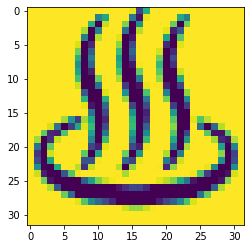

In [18]:
plt.imshow(all_imgs[0])
plt.show()

In [19]:
#train_set['seq_ind'][0]
train_set['seq_ind'].shape + all_imgs.shape[1:]

train_set['seq_ind'].shape[0]

18810

In [20]:
x_train = np.empty(shape=train_set['seq_ind'].shape + all_imgs.shape[1:],
                   dtype=float)

for i in range(train_set['seq_ind'].shape[0]):
    x_train[i][0] = all_imgs[train_set['seq_ind'][i][0]]
    x_train[i][1] = all_imgs[train_set['seq_ind'][i][1]]

In [21]:
x_test = np.empty(shape=test_set['seq_ind'].shape + all_imgs.shape[1:],
                   dtype=float)

for i in range(test_set['seq_ind'].shape[0]):
    x_test[i][0] = all_imgs[test_set['seq_ind'][i][0]]
    x_test[i][1] = all_imgs[test_set['seq_ind'][i][1]]
    
x_test.shape

(990, 2, 32, 32)

In [22]:
x_train.shape

(18810, 2, 32, 32)

differnt?  False


<Figure size 432x288 with 0 Axes>

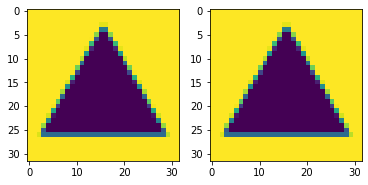

In [23]:
testi = 0
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_train[testi][0])
axarr[1].imshow(x_train[testi][1])

print("differnt? ", bool(train_set['y'][testi]))

differnt?  True


<Figure size 432x288 with 0 Axes>

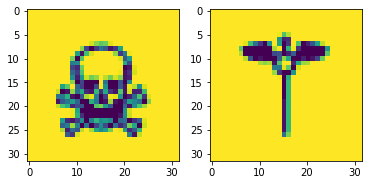

In [24]:
testi = 1
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_train[testi][0])
axarr[1].imshow(x_train[testi][1])

print("differnt? ", bool(train_set['y'][testi]))

# Model

In [107]:
x = keras.layers.Input(x_train.shape[1:])
#y =x
y = ESBN(output_dim=2)(x)
print("After ESBN shapes : ", y.shape)
#y = keras.layers.Flatten()(y)
#y = tf.keras.layers.Softmax()(y)
#y = keras.layers.Dense(1, activation=keras.activations.sigmoid)(y)
#y = keras.layers.Flatten()(y)
y = keras.layers.Dense(1, activation=keras.activations.softmax)(y)
#Class tokens

model = keras.Model(x, y)

images shape:  (None, 2, 32, 32)
b shape  2
out size after creation:  Tensor("esbn_18/TensorListLength:0", shape=(), dtype=int32)
in loop single shape: (None, 32, 32)
z :  (None, 64)
kx  Tensor("esbn_18/zeros_4:0", shape=(None, 65), dtype=float32)
hx :  (None, 512)
cx :  Tensor("esbn_18/zeros_3:0", shape=(None, 512), dtype=float32)
Mk :  (None, 64)
kw :  (None, 64)
Mv :  (None, 64)
z :  (None, 64)
i :  0
then i :  1
y :  (None, 2)
?? out :  Tensor("esbn_18/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 2), dtype=float32)
out :  Tensor("esbn_18/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 2), dtype=float32)
After ESBN shapes :  (None, 2)


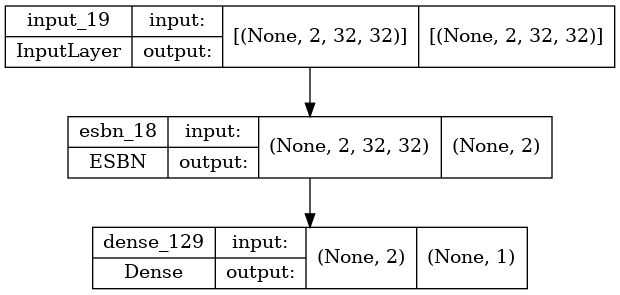

In [108]:
keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [136]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2, 32, 32)]       0         
                                                                 
 esbn_18 (ESBN)              (None, 2)                 1333539   
                                                                 
 dense_129 (Dense)           (None, 1)                 3         
                                                                 
Total params: 1,333,542
Trainable params: 1,333,542
Non-trainable params: 0
_________________________________________________________________


In [128]:
lr = 0.000001
# model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               optimizer=keras.optimizers.Adam(lr),
#               metrics=keras.metrics.SparseCategoricalAccuracy())

model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(lr),
              metrics=keras.metrics.BinaryAccuracy())

In [129]:
testi = 0
prediction = model.predict(x_train[testi:testi+4])
prediction

images shape:  (None, 2, 32, 32)
b shape  2
out size after creation:  Tensor("model_15/esbn_18/TensorListLength:0", shape=(), dtype=int32)
in loop single shape: (None, 32, 32)
z :  (None, 64)
kx  Tensor("model_15/esbn_18/zeros_4:0", shape=(None, 65), dtype=float32)
hx :  (None, 512)
cx :  Tensor("model_15/esbn_18/zeros_3:0", shape=(None, 512), dtype=float32)
Mk :  (None, 64)
kw :  (None, 64)
Mv :  (None, 64)
z :  (None, 64)
i :  0
then i :  1
y :  (None, 2)
?? out :  Tensor("model_15/esbn_18/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 2), dtype=float32)
out :  Tensor("model_15/esbn_18/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 2), dtype=float32)


array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [130]:
train_set['y'][testi:testi+4]

array([0, 1, 1, 1])

In [131]:
keras.metrics.BinaryAccuracy()(train_set['y'][testi:testi+4],prediction)

<tf.Tensor: shape=(), dtype=float32, numpy=0.75>

In [132]:
epochs = 20
history = model.fit(x_train, train_set['y'],
                    batch_size=train_batch_size,
                    epochs=epochs,
                    validation_split=0.2,#1-train_proportion,
                    verbose=1)

Epoch 1/20
images shape:  (None, 2, 32, 32)
b shape  2
out size after creation:  Tensor("model_15/esbn_18/TensorListLength:0", shape=(), dtype=int32)
in loop single shape: (None, 32, 32)
z :  (None, 64)
kx  Tensor("model_15/esbn_18/zeros_4:0", shape=(None, 65), dtype=float32)
hx :  (None, 512)
cx :  Tensor("model_15/esbn_18/zeros_3:0", shape=(None, 512), dtype=float32)
Mk :  (None, 64)
kw :  (None, 64)
Mv :  (None, 64)
z :  (None, 64)
i :  0
then i :  1
y :  (None, 2)
?? out :  Tensor("model_15/esbn_18/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 2), dtype=float32)
out :  Tensor("model_15/esbn_18/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 2), dtype=float32)
images shape:  (None, 2, 32, 32)
b shape  2
out size after creation:  Tensor("model_15/esbn_18/TensorListLength:0", shape=(), dtype=int32)
in loop single shape: (None, 32, 32)
z :  (None, 64)
kx  Tensor("model_15/esbn_18/zeros_4:0", shape=(None, 65), dtype=float32)
hx :  (None, 512)
cx :  Tensor("model_15/esb

In [133]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

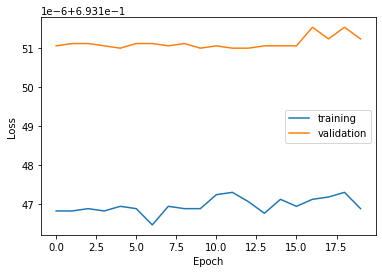

In [134]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

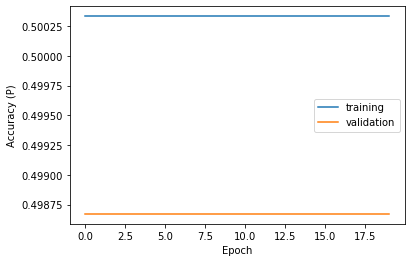

In [135]:
plt.plot(history.history['binary_accuracy'], label='training')
plt.plot(history.history['val_binary_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (P)')
plt.show()

# Test